In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

np.random.seed(12346)

In [2]:
debug = True

def debugger(debug, message):
    if debug:
        print(message)

In [3]:
# PARAMS
overtake_window = 2.0
circuit_length = 10.0
p_safety_car = 0.0

gamma_max = 0.4
alpha_max = 0.9

crash_delay = 7
pitstop_delay = 3
pitstop_error_probability = 0.05
pitstop_error_delay = 7

v_max = 10
skill_max = 5
craziness_max = 7

tyre_max_age = 0.3
tyre_spoil_per_lap = 0.05
tyre_spoil_per_overlap = 0.02
max_failed_attacks = 3

utilities_NN = [0,0]
utilities_AN = [3,-3]
utilities_AD_fail = [-0.5,-0.5]
utilities_AD_success = [2.5,-3.5]
utilities_AD_crash = [-crash_delay,-crash_delay]

starting_grid_gap = 0.1

In [4]:
# # PARAMS (a)
# overtake_window = 2.0
# circuit_length = 10.0

# gamma_max = 0.5

# crash_delay = 7
# pitstop_delay = 3
# pitstop_error_probability = 0.05
# pitstop_error_delay = 7

# v_max = 10
# skill_max = 5
# craziness_max = 7

# tyre_max_age = 0.3
# tyre_spoil_per_lap = 0.05
# tyre_spoil_per_overlap = 0.02
# max_failed_attacks = 3

# utilities_NN = [0,0]
# utilities_AN = [3,-3]
# utilities_AD_fail = [-0.5,-0.5]
# utilities_AD_success = [2.5,-3.5]
# utilities_AD_crash = [-crash_delay,-crash_delay]

In [5]:
def alpha(attacker, defender):
    v_term = (float(lap_df.Velocity[attacker]) - lap_df.Velocity[defender]) / v_max # lap_df.Velocity[attacker] # (or v_max)
    s_term = (starting_grid.Skill[attacker] - starting_grid.Skill[defender]) / skill_max # starting_grid.Skill[attacker] # (or skill_max)
    a = (v_term + s_term) #/ (lap_df.Velocity[attacker] + starting_grid.Skill[attacker])
    return min(max(a,0.1),alpha_max)

def gamma(attacker, defender):
    crazy = (starting_grid.Craziness[attacker] * starting_grid.Craziness[defender]) / craziness_max**2  - (starting_grid.Skill[attacker] * starting_grid.Skill[defender]) / skill_max**2
    crazy = crazy*gamma_max
    return min(max(crazy,0.02),gamma_max)

def FindEquilibria(alpha,gamma):
    NN_payoffs = np.array(utilities_NN)
    AN_payoffs = np.array(utilities_AN)
    AD_payoffs = (1.-alpha-gamma)*np.array(utilities_AD_fail) + alpha*np.array(utilities_AD_success) + gamma*np.array(utilities_AD_crash)
    #debugger(debug, 'AD_payoffs: ' + str(AD_payoffs))

    right_path = NN_payoffs
    right_choices = ['N','N']

    # Backward induction: defender's choice

    if (AD_payoffs[1] > AN_payoffs[1]) :
        left_path = AD_payoffs
        left_choices = ['A','D']
    elif (AD_payoffs[1] < AN_payoffs[1]) :
        left_path = AN_payoffs
        left_choices = ['A','N']
    else :
        # Assume generous
        if (AD_payoffs[0] > AN_payoffs[0]) :
            left_path = AD_payoffs
            left_choices = ['A','D']
        # Both playoffs equal: esticazzi
        else :
            left_path = AN_payoffs
            left_choices = ['A','N']

    
    # Backward induction: attacker's choice
    
    if (left_path[0] > right_path[0]) :
        return left_choices
    elif (left_path[0] < right_path[0]) :
        return right_choices
    else :
        # Assume generous
        if (left_path[1] > right_path[0]) :
            return left_choices
        # Both playoffs equal: esticazzi
        else :
            return right_choices

def flip_time(attacker, defender):
    aux_var = lap_df.Time[attacker]
    lap_df.loc[attacker,'Time'] = lap_df.Time[defender]
    lap_df.loc[defender,'Time'] = aux_var
    #lap_df.loc[attacker,'Failed_attacks'] = 0

def crash(attacker, defender):
    lap_df.loc[attacker,'Time'] = lap_df.Time[attacker] + crash_delay
    lap_df.loc[defender,'Time'] = lap_df.Time[defender] + crash_delay
    lap_df.loc[attacker,'Failed_attacks'] = 0

def update_failed_attack(attacker):
    lap_df.loc[attacker,'Failed_attacks'] += 1

def overtake_strategy_manager(attacker, defender):
    stop_attacking = True

    a = alpha(attacker,defender)
    g = gamma(attacker,defender)
    choices = FindEquilibria(a,g)
    
    if choices[0] == 'A' :
        if choices[1] == 'N' :
            # Free overtake
            flip_time(attacker, defender)
            lap_df.loc[attacker,'Tyre_life'] -= tyre_spoil_per_overlap
            debugger(debug,'-------- '+str(attacker)+' overtook for free '+str(defender)+' --------')
            return not stop_attacking
        else :
            dice = np.random.random()
            if dice < a :
                # Overtake
                flip_time(attacker, defender)
                lap_df.loc[attacker,'Tyre_life'] -= tyre_spoil_per_overlap
                lap_df.loc[defender,'Tyre_life'] -= tyre_spoil_per_overlap
                debugger(debug,'-------- '+str(attacker)+' overtook '+str(defender)+' --------')
                return not stop_attacking
            elif dice < a + g :
                # Crash
                crash(attacker, defender)
                debugger(debug,'-------- '+str(attacker)+' and '+str(defender)+' CRASHED!!!'+' --------')
                return stop_attacking
            else : 
                # Failed attack
                update_failed_attack(attacker)
                lap_df.loc[attacker,'Tyre_life'] -= tyre_spoil_per_overlap
                lap_df.loc[defender,'Tyre_life'] -= tyre_spoil_per_overlap
                debugger(debug,'-------- '+str(attacker)+' failed attack to '+str(defender)+' --------')
                return stop_attacking
    else :
        return stop_attacking

In [6]:
def augment_tyre_age():
    lap_df.loc[lap_df.index,'Tyre_life'] -= tyre_spoil_per_lap / lap_df['Skill']

def pitstop():
    stopping_pilots = lap_df[lap_df.Pitstop_will == True].index
    lap_df.loc[stopping_pilots,'Pitstop_will'] = False
    lap_df.loc[stopping_pilots,'Tyre_life'] = 1.0
    lap_df.loc[stopping_pilots,'Failed_attacks'] = 0
    if np.random.random() < pitstop_error_probability:
        lap_df.loc[stopping_pilots,'Time'] += pitstop_error_delay
    else: 
        lap_df.loc[stopping_pilots,'Time'] += pitstop_delay
    
def check_tyre():
    tired_tyres = lap_df[lap_df.Tyre_life <= tyre_max_age].index
    lap_df.loc[tired_tyres,'Pitstop_will'] = True

def check_undercutters():
    undercutters = lap_df[lap_df.Failed_attacks >= max_failed_attacks].index
    lap_df.loc[undercutters,'Pitstop_will'] = True

def update_velocity():
    lap_df.loc[lap_df.index,'Velocity'] = starting_grid['Velocity'] * lap_df['Tyre_life']

def update_total_time():
    Time_ordered_rank = lap_df.sort_values('Time',ascending=False).index
    
    for i in range(len(Time_ordered_rank)-1):
        pilot_of_interest = Time_ordered_rank[i]
        opponent = Time_ordered_rank[i+1]
        pilot_projected_time = projected_time_lap(pilot_of_interest)
        opponent_projected_time =  projected_time_lap(opponent)
        lap_df.loc[pilot_of_interest,'Time'] = max(pilot_projected_time,opponent_projected_time+0.1)

    lap_df.loc[Time_ordered_rank[-1],'Time'] += circuit_length / lap_df.Velocity[Time_ordered_rank[-1]]

    if np.random.random() < p_safety_car:
        lap_df.loc[Time_ordered_rank, 'Time'] = lap_df.Time[Time_ordered_rank[0]] - np.arange(len(lap_df.index)) * starting_grid_gap
        print('------------ SAFETY CAR ------------')


def projected_time_lap(pilot_idx):
    return lap_df.Time[pilot_idx] + circuit_length / lap_df.Velocity[pilot_idx]



def advance_to_following_lap():
    augment_tyre_age()
    check_tyre()
    check_undercutters()
    pitstop()
    update_velocity()
    update_total_time()


def manager_attacks_of_single_pilot(attacker,count_attacks): # INTERRUPT IF FAILED
    Victims = lap_df[(lap_df.Time < lap_df.Time[attacker]) & (lap_df.Time > lap_df.Time[attacker] - overtake_window)].sort_values('Time',ascending=False).index
    for victim in Victims:
        stop_attacking = overtake_strategy_manager(attacker,victim)
        count_attacks += not stop_attacking
        if stop_attacking:
            break
    return count_attacks

def perform_all_overtakes(count_attacks):
    attacking_order = lap_df.sort_values('Time',ascending=False).index
    for attacker in attacking_order:
        count_attacks = manager_attacks_of_single_pilot(attacker,count_attacks)
    return count_attacks

def update_lap_df(lap_df, lap_number, count_attacks, Display=False):

    count_attacks = perform_all_overtakes(count_attacks)

    advance_to_following_lap()

    lap_df = lap_df.sort_values('Time')
    new_name = 'Lap_'+str(lap_number)
    all_times[new_name] = lap_df.Time


    if Display:
        print(':::::::::::::: '+'LAP NUMBER '+str(lap_number)+' ::::::::::::::')

        for pilot in lap_df.index:
            print(pilot+': ', lap_df.Time[pilot])

    return lap_df, lap_number+1, count_attacks


In [7]:
grid = pd.read_csv('driversGT.csv')
grid = grid.sort_values('Q3', ascending = False)
grid['Pitstop_will'] = False
grid['Failed_attacks'] = 0
grid['Time'] = np.arange(len(grid)) * starting_grid_gap
grid


,code,forename,surname,vel,skill,craziness,tyre_life,Q3,Pitstop_will,Failed_attacks,Time
18,MAZ,Nikita,Mazepin,4.0,1.0,5,1.0,20,False,0,0.0
19,MSC,Mick,Schumacher,4.0,1.5,7,1.0,19,False,0,0.1
17,GIO,Antonio,Giovinazzi,5.0,1.5,2,1.0,18,False,0,0.2
15,LAT,Nicholas,Latifi,5.5,1.5,6,1.0,17,False,0,0.3
16,RAI,Kimi,Raikkonen,5.0,4.0,4,1.0,16,False,0,0.4
14,RUS,George,Russell,5.5,2.0,4,1.0,15,False,0,0.5
10,TSU,Yuki,Tsunoda,7.0,2.0,6,1.0,14,False,0,0.6
12,STR,Lance,Stroll,6.5,2.0,6,1.0,13,False,0,0.7
13,VET,Sebastian,Vettel,6.5,2.5,2,1.0,12,False,0,0.8
8,OCO,Esteban,Ocon,7.5,2.5,1,1.0,11,False,0,0.9


In [8]:
#pilots = ['A','B','C','D','E']
#vels = [10,10,8,9,10] #levels: 1-10, corresponding to max velocity of each car
#tot_time = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8] 
#skills = [3,2,4,5,5] #stars: 1-5
#craziness = [1,7,7,4,2] #levels: 1-7
#tyre_life = [0.8,0.9,0.7,0.9,1,0.8,0.9,0.7,0.9,1,0.8,0.9,0.7,0.9,1,0.8,0.9,0.7,0.9] # %
#pitstop_will = [False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False] # 
#failed_attacks = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
starting_grid = pd.DataFrame(zip(grid["code"],grid["vel"],grid["Time"],grid["skill"],grid["craziness"],grid["tyre_life"],grid["Pitstop_will"],grid["Failed_attacks"]), \
                            columns=['Pilot','Velocity','Time','Skill','Craziness','Tyre_life','Pitstop_will','Failed_attacks'])
starting_grid = starting_grid.set_index('Pilot')
starting_grid

,Velocity,Time,Skill,Craziness,Tyre_life,Pitstop_will,Failed_attacks
Pilot,,,,,,,
MAZ,4.0,0.0,1.0,5,1.0,False,0
MSC,4.0,0.1,1.5,7,1.0,False,0
GIO,5.0,0.2,1.5,2,1.0,False,0
LAT,5.5,0.3,1.5,6,1.0,False,0
RAI,5.0,0.4,4.0,4,1.0,False,0
RUS,5.5,0.5,2.0,4,1.0,False,0
TSU,7.0,0.6,2.0,6,1.0,False,0
STR,6.5,0.7,2.0,6,1.0,False,0
VET,6.5,0.8,2.5,2,1.0,False,0


In [9]:
lap_df = starting_grid.copy()
lap_df.sort_values('Time')

,Velocity,Time,Skill,Craziness,Tyre_life,Pitstop_will,Failed_attacks
Pilot,,,,,,,
MAZ,4.0,0.0,1.0,5,1.0,False,0
MSC,4.0,0.1,1.5,7,1.0,False,0
GIO,5.0,0.2,1.5,2,1.0,False,0
LAT,5.5,0.3,1.5,6,1.0,False,0
RAI,5.0,0.4,4.0,4,1.0,False,0
RUS,5.5,0.5,2.0,4,1.0,False,0
TSU,7.0,0.6,2.0,6,1.0,False,0
STR,6.5,0.7,2.0,6,1.0,False,0
VET,6.5,0.8,2.5,2,1.0,False,0


In [10]:
positions = pd.DataFrame(pd.Series(np.arange(len(lap_df.index)), index = lap_df.sort_values('Time').index))
positions

,0
Pilot,
MAZ,0
MSC,1
GIO,2
LAT,3
RAI,4
RUS,5
TSU,6
STR,7
VET,8


In [11]:
import time
start_time = time.time()
lap_number = 1
total_laps = 2000    # 300 should suffice for set of param (a)
number_attacks_investigated = [0]
count_attacks = 0

all_times = pd.DataFrame(lap_df.Time).rename(columns={'Time':'Lap_0'})

start_time = time.time()
CPU_time = []

for i in range(total_laps):
    lap_df, lap_number, count_attacks = update_lap_df(lap_df,lap_number,count_attacks,Display=False)
    number_attacks_investigated.append(count_attacks)
    if i % 10 == 0:
        CPU_time.append(time.time() - start_time)


-------- PER failed attack to NOR --------
-------- RAI overtook LAT --------
-------- RAI overtook GIO --------
-------- RAI overtook for free MSC --------
-------- RAI overtook for free MAZ --------
-------- PER overtook for free GIO --------
-------- PER overtook for free MSC --------
-------- HAM failed attack to NOR --------
-------- BOT overtook for free MAZ --------
-------- BOT failed attack to RIC --------
-------- SAI overtook GAS --------
-------- LEC overtook for free LAT --------
-------- LEC overtook OCO --------
-------- LEC overtook for free TSU --------
-------- LEC overtook for free RUS --------
-------- LEC overtook VET --------
-------- LEC failed attack to ALO --------
-------- ALO overtook STR --------
-------- NOR overtook for free MSC --------
-------- NOR overtook for free MAZ --------
-------- VER overtook SAI --------
-------- VER failed attack to ALO --------
-------- ALO and LAT CRASHED!!! --------
-------- RAI overtook RUS --------
-------- HAM failed atta

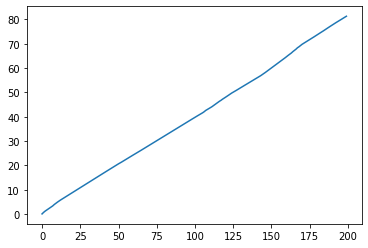

In [12]:
CPU_time = np.array(CPU_time)
t = np.arange(1,total_laps,10) 
t

plt.plot(CPU_time)

In [13]:
positions = all_times.copy()

for col in all_times.columns:
    for idx in all_times.index:
        t = all_times.loc[idx,col]
        data_col = all_times[col]
        positions.loc[idx,col] = int(data_col[data_col > t].count()) 

positions

,Lap_0,Lap_1,Lap_2,Lap_3,Lap_4,Lap_5,Lap_6,Lap_7,Lap_8,Lap_9,...,Lap_1991,Lap_1992,Lap_1993,Lap_1994,Lap_1995,Lap_1996,Lap_1997,Lap_1998,Lap_1999,Lap_2000
Pilot,,,,,,,,,,,,,,,,,,,,,
MAZ,19.0,7.0,3.0,4.0,3.0,3.0,3.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MSC,18.0,3.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GIO,17.0,2.0,0.0,3.0,2.0,2.0,2.0,2.0,0.0,0.0,...,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
LAT,16.0,12.0,7.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
RAI,15.0,19.0,9.0,7.0,6.0,7.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
RUS,14.0,15.0,10.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
TSU,13.0,14.0,8.0,8.0,7.0,8.0,8.0,7.0,7.0,7.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
STR,12.0,18.0,18.0,14.0,13.0,12.0,12.0,12.0,11.0,10.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
VET,11.0,16.0,17.0,12.0,10.0,10.0,11.0,11.0,12.0,11.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0


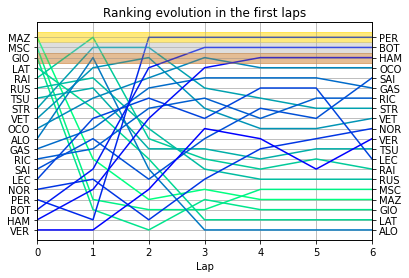

In [15]:
final_lap_range = 7 #total_laps for all
title_of_plot = 'Ranking evolution in the first laps'

x_axis = np.arange(final_lap_range)
x_axis_plot = x_axis
fig, ax1 = plt.subplots()

positions_df = positions.reset_index()
plot_df = positions_df.iloc[:,0:final_lap_range+1]

pd.plotting.parallel_coordinates(plot_df,'Pilot',ax=ax1,colormap='winter_r',axvlines = False,sort_labels = False)
# pd.plotting.parallel_coordinates(plot_df,'ciao',colormap='winter',axvlines = False)
ax1.get_legend().remove()

if final_lap_range > 10: 
    x_axis = []
    ax1.grid(alpha=0)

first_lap = 'Lap_0'
plot_label_1 = plot_df.Pilot[plot_df.sort_values(first_lap).index]
ax1.plot(plot_label_1, alpha=0)

last_lap = 'Lap_'+str(final_lap_range-1)
plot_label_2 = plot_df.Pilot[plot_df.sort_values(last_lap).index]
ax2 = ax1.twinx()
ax2.plot(plot_label_2, alpha=0)

ax2.set_xticklabels(x_axis)


Gold = '#FFD700'
Silver = '#C0C0C0'
Bronze = '#CD7F32'
ax1.fill_between(x_axis_plot, 19.5, 18.5, color=Gold, alpha=0.3)
ax2.fill_between(x_axis_plot, 19.5, 18.5, color=Gold, alpha=0.3, label = '$1^{st}$')
ax1.fill_between(x_axis_plot, 18.5, 17.5, color=Silver, alpha=0.3)
ax2.fill_between(x_axis_plot, 18.5, 17.5, color=Silver, alpha=0.3, label = '$2^{st}$')
ax1.fill_between(x_axis_plot, 17.5, 16.5, color=Bronze, alpha=0.3)
ax2.fill_between(x_axis_plot, 17.5, 16.5, color=Bronze, alpha=0.3, label = '$3^{st}$')
ax1.set_xlabel('Lap')
ax2.set_xlabel('Lap')

plt.title(title_of_plot)
plt.show()

In [15]:
positions_df = pd.DataFrame(positions, columns = np.arange(len(starting_grid.index), 0, -1)).T
pd.plotting.parallel_coordinates(positions_df,0,colormap='winter',axvlines = False).invert_yaxis()
plt.grid()
#plt.ylim([0,5])
plt.xlim([290,300])
plt.legend(bbox_to_anchor=[1.01,1.01,0.01,0.01])
plt.show()

HAM:  3488.539643664546
BOT:  3585.7939694414895
VER:  3677.104160856986
PER:  3721.5042478080136
LEC:  3942.284155933924
SAI:  3976.2762864219526
NOR:  4398.560365490991
RIC:  4447.76288787827
ALO:  4707.581610767378
OCO:  4721.666626404063
GAS:  4993.951129506595
TSU:  5034.280122683781
VET:  5406.654806426485
RAI:  6980.914496110033
RUS:  6982.223963921562
STR:  6991.04378539814
GIO:  7554.115055846556
LAT:  7554.215055846556
MSC:  9479.227397549394
MAZ:  9479.327397549394


In [ ]:
for pilot in lap_df.index:
            print(pilot+': ', lap_df.Time[pilot])

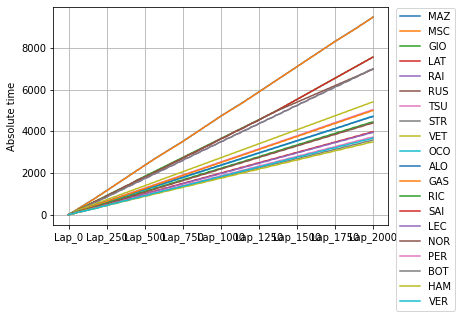

In [16]:
all_times.T.plot(legend=False)
plt.ylabel('Absolute time')
plt.grid()
plt.legend(bbox_to_anchor=[1.01,1.01,0.01,0.01])
plt.show()
#plt.savefig('im.pdf', bbox_inches='tight', dpi=150)

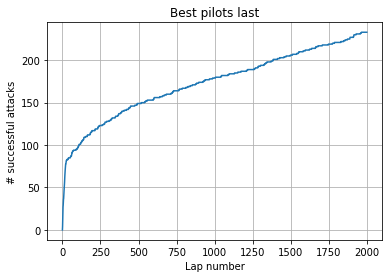

In [17]:
plt.plot(np.arange(lap_number),number_attacks_investigated)
plt.title('Best pilots last')
plt.ylabel('# successful attacks')
plt.xlabel('Lap number')
plt.grid()
#plt.show()
plt.savefig('plot1.pdf')


<ipython-input-29-6333702297f5>:8: RuntimeWarning: invalid value encountered in true_divide
  attacks_BF_rel_diff = np.diff(attacks_BF)/attacks_BF[1:]


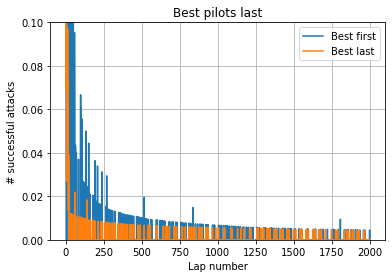

In [29]:
# Grid: 0.1
# np.savetxt('Successful_attacks_best_last.txt', number_attacks_investigated)
# np.savetxt('Successful_attacks_best_first.txt', number_attacks_investigated)

attacks_BF = np.loadtxt('Successful_attacks_best_first.txt')
attacks_BL = np.loadtxt('Successful_attacks_best_last.txt')

attacks_BF_rel_diff = np.diff(attacks_BF)/attacks_BF[1:]
attacks_BL_rel_diff = np.diff(attacks_BL)/attacks_BL[1:]

plt.plot(np.arange(lap_number-1),attacks_BF_rel_diff, label = 'Best first')
plt.plot(np.arange(lap_number-1),attacks_BL_rel_diff, label = 'Best last')
plt.title('Best pilots last')
plt.ylabel('# successful attacks')
plt.xlabel('Lap number')
plt.grid()
plt.legend()
plt.ylim([0,0.1])
plt.show()
# plt.savefig('plot1.pdf')

In [19]:
for a in np.arange(0,0.9,0.1):
    for g in np.arange(0,0.1,0.05):
        print('alpha:',a,' gamma:',g)
        print(FindEquilibria(a,g))

In [20]:
# for a in np.arange(0,0.9,0.1):
#     for g in np.arange(0,0.2,0.05):
#         print('alpha:',a,' gamma:',g)
#         print(FindEquilibria(a,g))





# def FindEquilibria(alpha,gamma):
#     NN_payoffs = np.array([0,0])
#     AN_payoffs = np.array([3,-3])
#     AD_payoffs = (1.-alpha-gamma)*np.array([-1,-1]) + alpha*np.array([2,-4]) + gamma*np.array([-10,-10])
#     print(AD_payoffs)

#     if AD_payoffs[1] > AN_payoffs[1]:
#         if AD_payoffs[0] > NN_payoffs[0]:
#             return [('A', 'D')]
#         elif AD_payoffs[0] < NN_payoffs[0]:
#             return [('N', 'N')]
#         else:  #Assume non-generous attacker
#             if AD_payoffs[1] > NN_payoffs[1]:
#                 return [('N', 'N')]
#             elif AD_payoffs[1] < NN_payoffs[1]:
#                 return [('A', 'D')]
#     elif AD_payoffs[1] < AN_payoffs[1]:
#         if AN_payoffs[0] > NN_payoffs[0]:
#             return [('A', 'D')]
#         elif AN_payoffs[0] < NN_payoffs[0]:
#             return [('N', 'N')]
#         else:  #Assume non-generous attacker
#             if AN_payoffs[1] > NN_payoffs[1]:
#                 return [('N', 'N')]
#             elif AN_payoffs[1] < NN_payoffs[1]:
#                 return [('A', 'D')]
#     else:
#         if AD_payoffs[0] < AN_payoffs[0]:
#             if AD_payoffs[0] > NN_payoffs[0]:
#                 return [('A', 'D')]
#             elif AD_payoffs[0] < NN_payoffs[0]:
#                 return [('N', 'N')]
#             else:  #Assume non-generous attacker
#                 if AD_payoffs[1] > NN_payoffs[1]:
#                     return [('N', 'N')]
#                 elif AD_payoffs[1] < NN_payoffs[1]:
#                     return [('A', 'D')]
#         elif AD_payoffs[0] > AN_payoffs[0]:
#             if AN_payoffs[0] > NN_payoffs[0]:
#                 return [('A', 'D')]
#             elif AN_payoffs[0] < NN_payoffs[0]:
#                 return [('N', 'N')]
#             else:  #Assume non-generous attacker
#                 if AN_payoffs[1] > NN_payoffs[1]:
#                     return [('N', 'N')]
#                 elif AN_payoffs[1] < NN_payoffs[1]:
#                     return [('A', 'D')]

# def Nature_Average(alpha,gamma):
#     return (1.-alpha-gamma)*np.array([-1,-1]) + alpha*np.array([2,-4]) + gamma*np.array([-10,-10])
